In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import re

In [580]:
# This function is used to graph and chart the stock data
def chart(data):
    #Load the Data
    df = pd.read_csv(data)
    
    #Create a simple moving average with a 30 day window
    SMA_30 = pd.DataFrame()
    SMA_30['Adj_Close_Price'] = df['Adj Close'].rolling(window = 30).mean()
    SMA_30
    
    # Short moving average for 100 days
    SMA_100 = pd.DataFrame()
    SMA_100['Adj_close_price'] = df['Adj Close'].rolling(window = 100).mean()
    SMA_100
    
    # Create a dataframe of all adj close prices
    data = pd.DataFrame()
    data['Date'] = df['Date']
    data['AAL_adj_close'] = df['Adj Close']
    data['SMA_30'] = SMA_30['Adj_Close_Price']
    data['SMA_100']= SMA_100['Adj_close_price']
    
    #Create a Function to signal when to buy and sell
    def buy_sell(data):
        sig_price_buy = []
        sig_price_sell = []
        flag = -1

        for i in range(len(data)):
            if data['SMA_30'][i] > data['SMA_100'][i]:
                if flag != 1:
                    sig_price_buy.append(data['AAL_adj_close'][i])
                    sig_price_sell.append(np.nan)
                    flag = 1
                else:
                    sig_price_buy.append(np.nan)
                    sig_price_sell.append(np.nan)
            elif data['SMA_30'][i] < data['SMA_100'][i]:
                if flag !=0:
                    sig_price_buy.append(np.nan)
                    sig_price_sell.append(data['AAL_adj_close'][i])
                    flag = 0
                else:
                    sig_price_buy.append(np.nan)
                    sig_price_sell.append(np.nan)
            else:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(np.nan)

        return (sig_price_buy, sig_price_sell)
    
    #store the buy and sell data into a variable
    buy_sell = buy_sell(data)
    data['buy_signal_price'] = buy_sell[0]
    data['sell_signal_price']=buy_sell[1]
    
    #Looking for the dates of the buy signals
    buy_dates = data.loc[data['buy_signal_price']>0]
    
    #Looking for the dates of the sell signals
    sell_dates = data.loc[data['sell_signal_price']>0]
    
    #Dropping uneccessary columns
    buy_dates.drop(columns = ['sell_signal_price', 'SMA_30', 'SMA_100'], inplace = True)
    sell_dates.drop(columns = ['buy_signal_price', 'SMA_30', 'SMA_100'], inplace = True)
    
    # DF of dates with prices
    dates = pd.concat([buy_dates, sell_dates],sort = True)
    
    # Now to organize by the dates, drop adj_close price column, and make date the index
    dates.sort_values(by = 'Date', inplace = True)
    dates.drop(columns = ['AAL_adj_close'],inplace = True)
    dates.set_index('Date', inplace = True)

    #visualize data and strategy to buy and sell stock
    ab = plt.figure(figsize=(20,12))
    combined.Date = pd.to_datetime(combined.Date).dt.strftime('%b %d %Y')
    last_date = combined['Date'].iloc[-1]
    first_date = combined['Date'].iloc[0]
    plt.plot(data['AAL_adj_close'],label = 'PMAC', alpha = 0.35)
    plt.plot(data['SMA_30'], label = 'SMA30', alpha = 0.35)
    plt.plot(data['SMA_100'],label = 'SMA100', alpha = 0.35)
    plt.scatter(data.index, data['buy_signal_price'],label = 'Buy',marker = '^', color = 'green')
    plt.scatter(data.index, data['sell_signal_price'], label = 'Sell', marker = 'v', color = 'red')
    plt.title('{} adj close price history buy and sell signals'.format(x))
    plt.xlabel('{} - {}'.format(first_date, last_date))
    plt.ylabel('Adj close price USD')
    plt.legend()
    plt.show()
    print(dates)

    return dates


In [581]:
# Webscraping method to pull past 5 dates. 
def new_data(stock_name):
    # Now that we saved our chart from yahoo.com, we can scrape new data to update our csv file
    # This cell's code has already been written above in seperate cells. This cell condenses the retreival process.
    page = requests.get('https://finance.yahoo.com/quote/{}/history?p={}'.format(stock_name, stock_name))
    soup = BeautifulSoup(page.content, 'html.parser')
    info = soup.find('table', class_ = 'W(100%) M(0)')
    columns = info.find_all('td')

    # First new date
    new_date = str(columns[0])
    new_date = new_date[-24:-12]
    
    # Retrieving new open price
    new_open_price = str(columns[1])
    new_open_price = new_open_price[-26:-12]
    new_open_price = new_open_price.replace("55","")
    new_open_price = re.sub('"|c|>|<|/|s|p|t|i|d|,|=',"",new_open_price)
    new_open_price = float(new_open_price)
    
    # Retrieving new adjusted close price
    new_adj_close_price = str(columns[5])
    new_adj_close_price = new_adj_close_price[-26:-8]
    new_adj_close_price = new_adj_close_price.replace("63","")
    new_adj_close_price = re.sub('"|>|<|/|s|p|t|i|d|=|,',"",new_adj_close_price)
    new_adj_close_price = float(new_adj_close_price)


    # Second Date
    second_date = str(columns[7])
    second_date = second_date[-24:-12]
    
    # Second open price
    second_open_price = str(columns[8])
    second_open_price = second_open_price[-26:-12]
    second_open_price = second_open_price.replace("70","")
    second_open_price = re.sub('"|>|<|/|s|p|t|i|d|=|,',"",second_open_price)
    second_open_price = float(second_open_price)
    
    # Second adjusted close price
    second_adj_close_price = str(columns[12])
    second_adj_close_price = second_adj_close_price[-26:-12]
    second_adj_close_price = second_adj_close_price.replace("78","")
    second_adj_close_price = re.sub('"|>|<|/|s|p|t|i|d|=|,',"",second_adj_close_price)
    second_adj_close_price = float(second_adj_close_price)

    # Third Date
    third_date = str(columns[14])
    third_date = third_date[-24:-12]
    
    # Third open price
    third_open_price = str(columns[15])
    third_open_price = third_open_price[-26:-8]
    third_open_price = third_open_price.replace("85","")
    third_open_price = re.sub('"|>|<|/|s|p|t|i|d|=|,',"",third_open_price)
    third_open_price = float(third_open_price)
    
    # Third adjusted close price
    third_adj_close_price = str(columns[19])
    third_adj_close_price = third_adj_close_price[-26:-8]
    third_adj_close_price = third_adj_close_price.replace("93","")
    third_adj_close_price = re.sub('"|>|<|/|s|p|t|i|d|=|,',"",third_adj_close_price)
    third_adj_close_price = float(third_adj_close_price)

    # Fouth Date
    fourth_date = str(columns[21])
    fourth_date = fourth_date[-24:-12]
    
    # Fourth open price
    fourth_open_price = str(columns[22])
    fourth_open_price = fourth_open_price[-26:-12]
    fourth_open_price = fourth_open_price.replace("100","")
    fourth_open_price = re.sub('"|>|<|/|s|p|t|i|d|=|,',"",fourth_open_price)
    fourth_open_price = float(fourth_open_price)
    
    # Fourth adjusted close price
    fourth_adj_close_price = str(columns[26])
    fourth_adj_close_price = fourth_adj_close_price[-26:-12]
    fourth_adj_close_price = fourth_adj_close_price.replace("108","")
    fourth_adj_close_price = re.sub('"|>|<|/|s|p|t|i|d|=|,',"",fourth_adj_close_price)
    fourth_adj_close_price = float(fourth_adj_close_price)

    # Fifth Date
    fifth_date = str(columns[28])
    fifth_date = fifth_date[-24:-12]
    
    # Fifth open price
    fifth_open_price = str(columns[29])
    fifth_open_price = fifth_open_price[-26:-12]
    fifth_open_price = fifth_open_price.replace("115","")
    fifth_open_price = re.sub('"|>|<|/|s|p|t|i|d|=|,',"",fifth_open_price)
    fifth_open_price = float(fifth_open_price)
    
    # Fifth adjusted close price
    fifth_adj_close_price = str(columns[33])
    fifth_adj_close_price = fifth_adj_close_price[-26:-12]
    fifth_adj_close_price = fifth_adj_close_price.replace("123","")
    fifth_adj_close_price = re.sub('"|>|<|/|s|p|t|i|d|=|,',"",fifth_adj_close_price)
    fifth_adj_close_price = float(fifth_adj_close_price)

    # Creating column_info dictionary to be uploaded to new df
    column_info = {'Date':[new_date, second_date, third_date, fourth_date, fifth_date],
            'Open':[new_open_price, second_open_price, third_open_price, fourth_open_price, fifth_open_price],
            'Adj Close':[new_adj_close_price, second_adj_close_price, third_adj_close_price, 
                         fourth_adj_close_price, fifth_adj_close_price]}
    
    # New df name of new_information. This is the newly webscraped data
    new_information = pd.DataFrame(data = column_info)
    
    # Change the 'Date' type to datetime so it can concat with pre-existing csv file
    new_information['Date'] = pd.to_datetime(new_information.Date)    
    
    return new_information

### The cell below combines the webscraping function as well as the SMA and graphing function for ease of use

 WMT


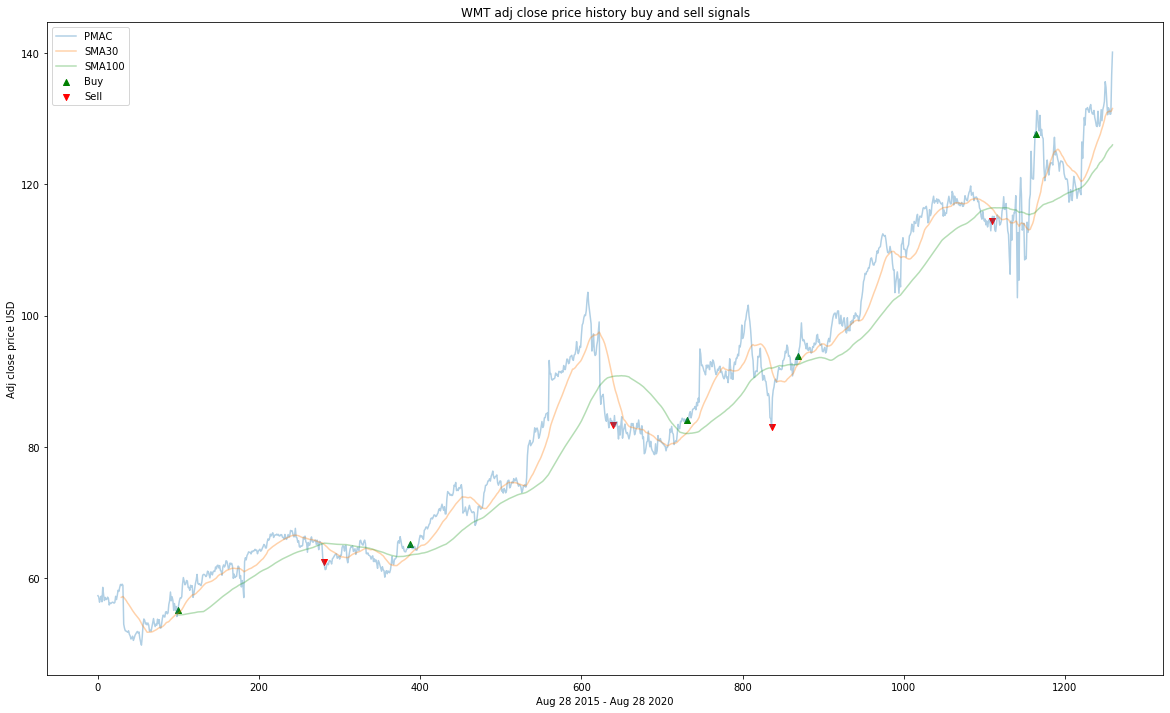

,buy_signal_price,sell_signal_price
Date,,
2016-01-21,55.114239,NaN
2016-10-07,NaN,62.517918
2017-03-14,65.293343,NaN
2018-03-14,NaN,83.355034
2018-07-25,84.100235,NaN
2018-12-24,NaN,83.037720
2019-02-12,93.826241,NaN
2020-01-27,NaN,114.374222
2020-04-15,127.671211,NaN


In [590]:
# Enter the stock you would like to see from your library
print('Enter Stock: ')
x = input()

# Create a df from the new_data function that will retrieve the stock information you enter
new_info = new_data(f'{x}')

# When the data is scraped, the time 00:00:00 also comes with it. That will not concat with our data
# so we need to get rid of it
new_info['Date'] = pd.to_datetime(new_info['Date']).dt.date

# Make sure the Date type is datetime so it concats properly
new_info['Date'] = pd.to_datetime(new_info.Date)

# Read in our existing data
stock_chart = pd.read_csv('{}.csv'.format(x))

# Make sure the Date type is datetime so it concats properly
stock_chart['Date'] = pd.to_datetime(stock_chart.Date)

# Now we combined our newly webscraped data with our csv file
combined = pd.concat([stock_chart, new_info], sort = False)
combined.sort_values(by = 'Date', inplace = True)
combined.reset_index(drop = True, inplace = True)
combined.drop_duplicates(subset = ['Date'], inplace = True)
combined = combined[['Date', 'Open', 'Adj Close']]

# Save the combined data to a csv file
combined.to_csv(f'{x}.csv', index = False)

# Now to use our chart function to get a visual representaion of our data
chart(f'{x}.csv')

In [591]:
# Double check webscraping and saving wprked by reading in one of the files and looking for the new date
pd.read_csv('AAPL.csv')

,Date,Open,Adj Close
0,2015-08-28,112.169998,104.692871
1,2015-08-31,112.029999,104.203110
2,2015-09-01,110.150002,99.545570
3,2015-09-02,110.230003,103.814980
4,2015-09-03,112.489998,101.994484
...,...,...,...
1255,2020-08-24,514.789978,503.429993
1256,2020-08-25,498.790009,499.299988
1257,2020-08-26,504.720000,506.090000
1258,2020-08-27,508.570000,500.040000


In [ ]:
### Next goal is to create a 